Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [469]:
import pandas as pd
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer

## 1. Exploratoray Data Analaysis  

Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [360]:
#read json file as dataframe
login_df = pd.read_json('logins.json',convert_dates=True)


In [361]:
#check the missing data
login_df['login_time'].isnull().sum()

0

In [362]:
login_df.sort_values('login_time', inplace=True)
login_df.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [363]:
#groypby 15min
login_df['loginCount']= 1
login_index=login_df.set_index('login_time')
login=login_index.resample('15T').sum()
#login = login.reset_index()
login.head()


,loginCount
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [364]:
login.isnull().sum().sum()

407

In [365]:
login = login.fillna(0)

In [366]:
login.isnull().sum()

loginCount    407
dtype: int64

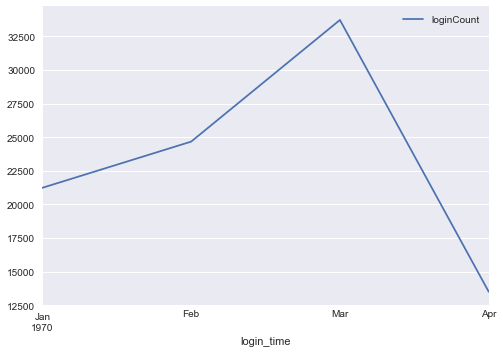

In [367]:
#show the daily login for each month
login.resample('M').sum().plot()
plt.show()

march has the highest login count and april has the lowest number of logins

In [368]:
login_jan = login['1970-01']
login_feb = login['1970-02']
login_mar= login['1970-03']
login_apr = login['1970-04']


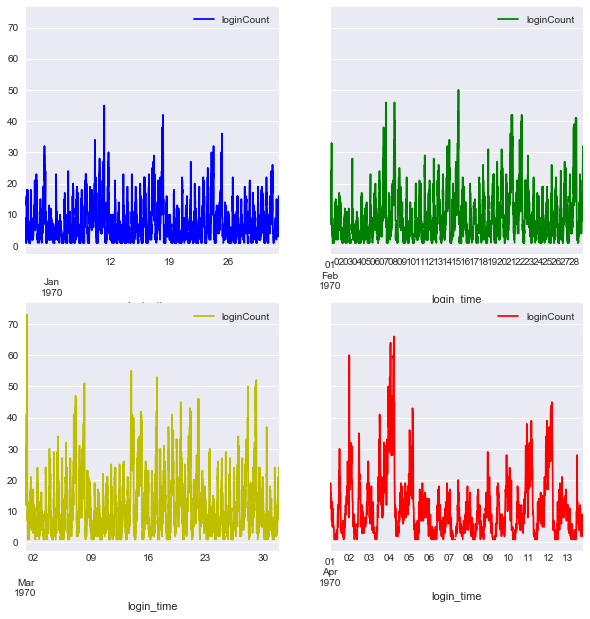

In [369]:
# visualize the data pattern
fig , ax1 = plt.subplots(nrows=2, ncols=2, figsize=(10,10),sharey=True)
login_jan.plot(ax=ax1[0,0],color='b')
login_feb.plot(ax=ax1[0,1],color='g')
login_mar.plot(ax=ax1[1,0],color='y')
login_apr.plot(ax=ax1[1,1],color='r')
plt.show()

Feb i sthe busyiest time of the year

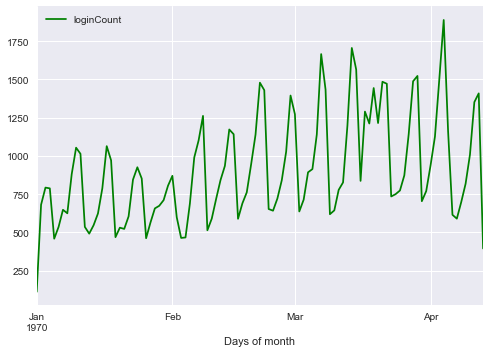

In [383]:
#Daily analysis
login.resample('D').sum().plot(color='g')
plt.xlabel('Days of month')
plt.show()

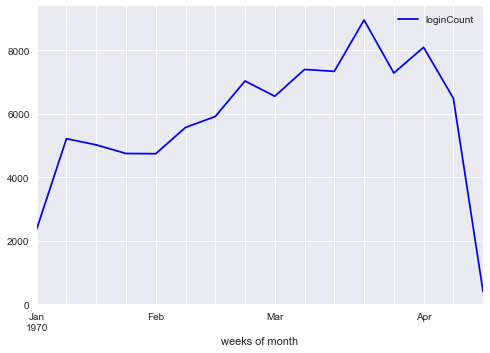

In [401]:
#weekly analysis
login.resample('W').sum().plot(color='b')
plt.xlabel('weeks of month')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.show()

In [372]:
# Extract hours and wekdays
login_df['hour'] = login_df['login_time'].dt.hour
login_df['wdays'] = login_df['login_time'].dt.weekday_name
login_df['month'] = login_df['login_time'].dt.month
login_df. head()

,login_time,loginCount,hour,wdays,month
6,1970-01-01 20:12:16,1,20,Thursday,1
0,1970-01-01 20:13:18,1,20,Thursday,1
1,1970-01-01 20:16:10,1,20,Thursday,1
3,1970-01-01 20:16:36,1,20,Thursday,1
2,1970-01-01 20:16:37,1,20,Thursday,1


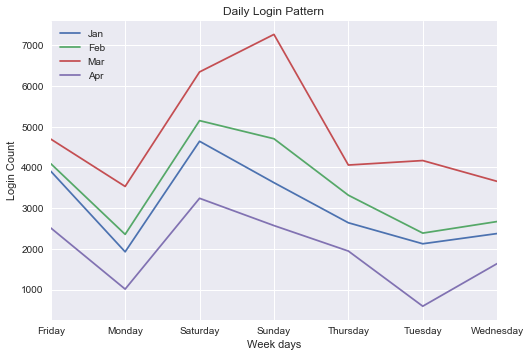

In [373]:
login_df[login_df.month==1].groupby('wdays')['loginCount'].sum().plot(label='Jan')
login_df[login_df.month==2].groupby('wdays')['loginCount'].sum().plot(label='Feb')
login_df[login_df.month==3].groupby('wdays')['loginCount'].sum().plot(label='Mar')
login_df[login_df.month==4].groupby('wdays')['loginCount'].sum().plot(label='Apr')
plt.xlabel('Week days')
plt.ylabel('Login Count')
plt.legend(loc='upper left')
plt.title('Daily Login Pattern')
plt.show()

In every month except march saturday has the highest number of login numbers.

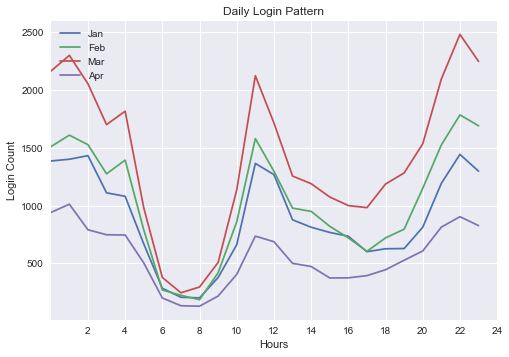

In [386]:
login_df[login_df.month==1].groupby('hour')['loginCount'].sum().plot(label='Jan')
login_df[login_df.month==2].groupby('hour')['loginCount'].sum().plot(label='Feb')
login_df[login_df.month==3].groupby('hour')['loginCount'].sum().plot(label='Mar')
login_df[login_df.month==4].groupby('hour')['loginCount'].sum().plot(label='Apr')
plt.xlabel('Hours')
plt.ylabel('Login Count')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24])
plt.legend(loc='upper left')
plt.title('Daily Login Pattern')
plt.show()

mostly the highest number of login count during a day is at 10pm-2am a d between 6 to 8 am is the lowest login time.

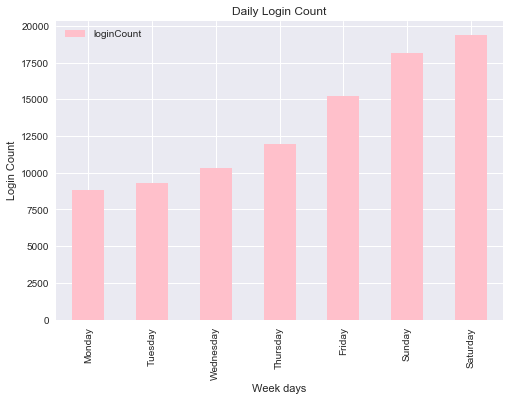

In [411]:
login_df.groupby('wdays')['loginCount'].sum().sort_values().plot(kind='bar', color='pink')
plt.xlabel('Week days')
plt.ylabel('Login Count')
plt.legend(loc='upper left')
plt.title('Daily Login Count')
plt.show()

In [445]:
hours = login_df
hours = hours[['loginCount', 'hour']]
hours = hours.groupby('hour').sum().reset_index()
hours.head()


,hour,loginCount
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


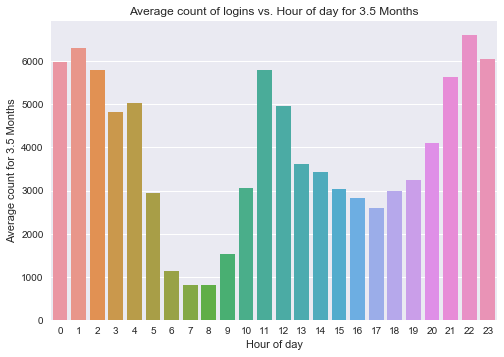

In [447]:
sns.barplot(x='hour', y='loginCount', data=hours)
plt.ylabel('Average count for 3.5 Months')
plt.xlabel('Hour of day')
plt.title('Average count of logins vs. Hour of day for 3.5 Months')
plt.show()

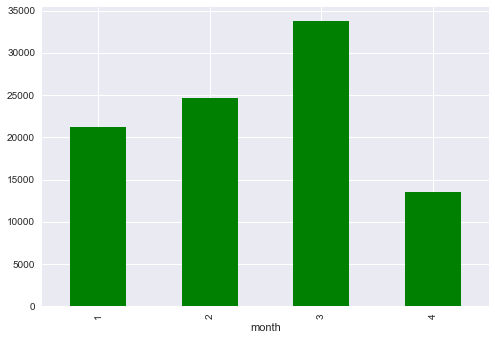

In [413]:
login_df.groupby('month')['loginCount'].sum().plot(kind='bar', color='g')
plt.show()

### Conclusion of part 1:

Amount of user-logins increase and peak torwards the weekend and saturday has the highest number of logins.

Amount of user-logins increase during day between 11 am to noon and during late-night  from 9 pm to 4 am.

Amount of user-logins increase in month March.



## 2 ‑ Experiment and metrics design  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

#### Solution:
    
For measure of success in this experience I would use A/B testing:  

A/B testing is a fantastic method for figuring out the best strategy for comparing the effectiveness of the proposed change. W

In this experiment I would like to test which way has more profit to business:  

1-Drivers work in both cities with reimbursing toll cost  

2-Drivers work in specific cities  

For this matter I would put half of the drivers for the new test so half of drivers work in both cities with reimbursing toll cost for few month and leave the other half. We test the followings:
In order to increase profit, the additional income brought in during the experiment must outweigh the toll cost reimbursements. We would use the key metric of profit after reimbursement.
 After a few months, we compare the profit made after reimbursement of toll costs. A more robust study could last a year. All driver partners are included in the study and the profit made for the year is compared to the previous years with time series analysis.

After getting our results, we would use a t-test to test for significance (p = 0.05) between each group.

we can run the hypothesis as  

H0--> Drivers work in both cities will reimburing cost is profitable and added more customers.    

H1--> Drivers work in both cities will reimburing cost is not profitable and does not added more customers.  



## Part 3 ‑ Predictive modeling   

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [485]:
#load Json data to dataframe
ultimate_json=open('ultimate_data_challenge.json','r')
ultimate_df=pd.DataFrame(json.loads(ultimate_json.read()))
ultimate_df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [486]:
ultimate_df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [487]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [488]:
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


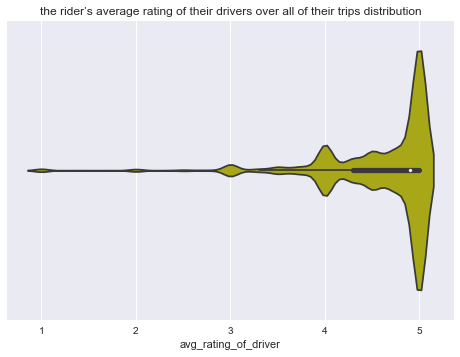

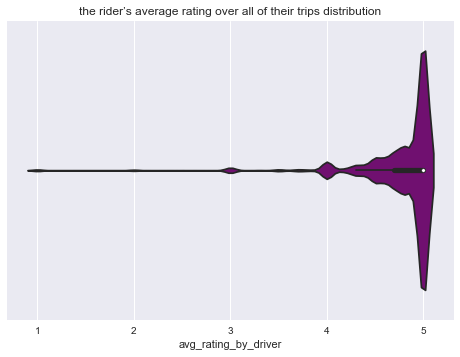

In [489]:
sns.violinplot(ultimate_df.avg_rating_of_driver,color='y')
plt.title('the rider’s average rating of their drivers over all of their trips distribution')
plt.show()
sns.violinplot(ultimate_df.avg_rating_by_driver ,color='purple')
plt.title('the rider’s average rating over all of their trips distribution')
plt.show()

Probably we would like to check for the central tendency of the data and replace the null accordingly. 
It is visible from the seaborne plot that data was not distribute normally. Therefore picking median to fill remaining values is a good choice.

In [490]:
for col in ['avg_rating_of_driver', 'avg_rating_by_driver']:
    ultimate_df[col] = Imputer(missing_values="NaN",strategy='mean').fit_transform(
                                    ultimate_df[col].values.reshape(-1, 1))

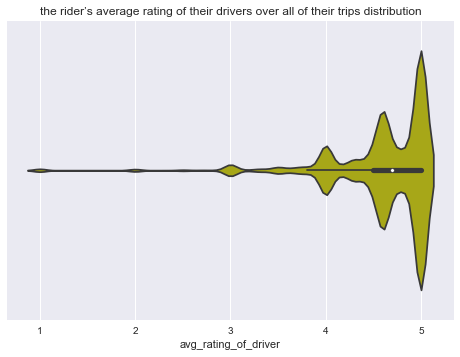

In [492]:
sns.violinplot(ultimate_df.avg_rating_of_driver,color='y')
plt.title('the rider’s average rating of their drivers over all of their trips distribution')
plt.show()

In [491]:
ultimate_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [493]:
#So for phone misising values we can use median which will be iphone.
ultimate_df.phone.fillna('iPhone',inplace=True)

In [495]:
ultimate_df.isnull().sum().sum()

0